In [131]:
import sys
print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:07:29) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [38]:
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import variation

#set max columns displayed to 100
pd.set_option('display.max_columns',100)

### TRAIN DATASET

In [3]:
# First, let's import the train dataset: daily historical data from January 2013 to October 2015.
sales = pd.read_csv('./Data/competitive-data-science-predict-future-sales/sales_train.csv')

In [4]:
sales.shape

(2935849, 6)

In [5]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Per Kaggle documentation, the columns in this dataset are:

- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

In [8]:
# Let's convert the date column from string to datetime type
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              datetime64[ns]
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB


In [10]:
# Determine if there are any null values in the dataset
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [11]:
# Determine if there are any duplicate rows in the dataset
sales.duplicated().any()

True

In [12]:
# Determine how many duplicate rows exists
sales.duplicated().sum()

6

In [13]:
# Drop duplicate rows
sales.drop_duplicates(inplace=True)
sales.shape

(2935843, 6)

In [14]:
# Determine the number of unique shop_id values in the dataset
len(sales.shop_id.value_counts())

60

In [15]:
# Determine the number of unique item_id values in the dataset
len(sales.item_id.value_counts())

21807

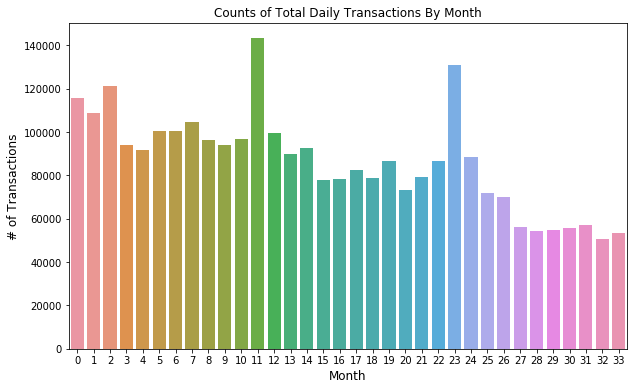

In [16]:
# Check how many total sales transactions there are in each month
monthly_sales_totals = sales.date_block_num.value_counts()
plt.figure(figsize=(10,6))
ax = sns.barplot(monthly_sales_totals.index, monthly_sales_totals.values)
plt.title("Counts of Total Daily Transactions By Month")
plt.ylabel("# of Transactions", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.show()

<b>FINDING:</b> December appears to be a high-volume month, while May appears to be a low-volume month. Other months also point to seasonality of the volume of purchases.

In [17]:
# Check distribution of month of transaction values for each shop
sales.groupby('shop_id')['date_block_num'].describe().T

shop_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59
count,9857.000000,5678.000000,25991.000000,25532.000000,38242.000000,38179.000000,82663.000000,58076.000000,3412.000000,3751.000000,21397.000000,499.0,34694.000000,17824.000000,36979.000000,59511.000000,52734.000000,22950.000000,53227.000000,63911.000000,1792.000000,58132.000000,45434.000000,6963.000000,53032.000000,186103.000000,53910.000000,105366.000000,142234.000000,49225.000000,50860.000000,235636.000000,7947.000000,5027.000000,5752.000000,58445.000000,306.0,39638.000000,46013.000000,13440.000000,4257.000000,41967.000000,109252.000000,39282.000000,39530.000000,35891.000000,66321.000000,56695.000000,21612.000000,15849.000000,65171.000000,44433.000000,43502.000000,52921.000000,143479.000000,34769.000000,69573.000000,117428.000000,71441.000000,42108.000000
mean,0.513747,0.525537,16.691855,15.927424,14.507740,16.520574,14.063269,14.853365,0.866061,18.944548,14.182128,25.0,17.484407,8.456744,14.700533,14.258725,13.562768,14.227015,13.454600,14.484893,26.671875,16.161907,14.645134,1.455838,14.689207,15.066350,14.201428,14.513154,14.811283,12.077583,11.074479,14.935341,2.489493,22.950467,25.989221,15.249722,33.0,13.845653,15.883055,23.520833,19.662203,13.466080,16.135860,11.758133,13.824817,13.846424,14.360851,16.592927,23.830326,22.462300,12.459576,12.461166,14.641879,14.886699,11.852585,20.666513,14.301511,15.116378,15.726432,14.301320
std,0.499836,0.499391,9.547010,9.418781,9.549651,9.146677,9.330895,9.427724,0.814302,9.239632,9.400191,0.0,9.643071,5.431443,9.883468,9.416648,9.712060,5.544127,9.855083,9.548045,5.992693,9.580284,9.705284,1.104115,9.148441,9.728439,9.559257,8.786275,9.454782,8.199808,7.322799,9.544102,1.689229,1.883741,4.242381,9.494405,0.0,10.126074,9.655999,5.709685,3.279946,9.151204,9.779877,7.241830,9.341741,9.315826,9.456020,9.641717,5.209350,6.223397,8.846800,8.930045,9.437649,9.377312,7.832074,7.897850,9.329751,8.872493,8.875159,9.560465
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.000000,0.000000,25.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,18.000000,0.000000,33.0,0.000000,0.000000,14.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,2.000000,2.000000,0.000000
25%,0.000000,0.000000,9.000000,8.000000,7.000000,9.000000,6.000000,7.000000,0.000000,9.000000,6.000000,25.0,10.000000,4.000000,6.000000,6.000000,5.000000,10.000000,5.000000,6.000000,21.000000,8.000000,6.000000,0.000000,7.000000,7.000000,6.000000,7.000000,7.000000,5.000000,5.000000,7.000000,1.000000,22.000000,23.000000,7.000000,33.0,4.000000,8.000000,19.000000,17.000000,6.000000,8.000000,6.000000,6.000000,6.000000,6.000000,9.000000,19.000000,17.000000,5.000000,5.000000,7.000000,7.000000,5.000000,15.000000,6.000000,7.000000,8.000000,6.000000
50%,1.000000,1.000000,17.000000,16.000000,14.000000,16.000000,13.000000,14.000000,1.000000,21.000000,13.000000,25.0,18.000000,8.000000,14.000000,13.000000,12.000000,14.000000,11.000000,13.000000,21.000000,16.000000,13.000000,1.000000,13.000000,14.000000,13.000000,14.000000,14.000000,11.000000,11.000000,14.000000,2.000000,23.000000,26.000000,14.000000,33.0,12.000000,16.000000,23.000000,20.000000,12.000000,16.000000,11.000000,13.000000,12.000000,13.000000,17.000000,23.000000,23.000000,11.000000,11.000000,14.000000,14.000000,11.000000,22.000000,13.000000,14.000000,15.000000,13.000000
75%,1.000000,1.000000,24.000000,24.000000,23.000000,24.000000,22.000000,23.000000,2.000000,21.000000,22.000000,25.0,25.000000,13.000000,23.000000,22.000000,22.000000,19.000000,22.000000,23.000000,33.000000,24.000000,23.000000,2.000000,22.000000,23.0000

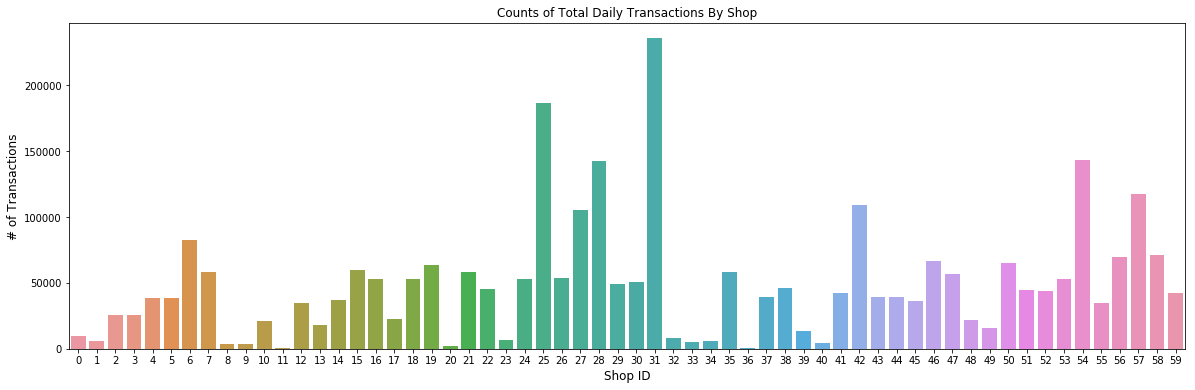

In [18]:
# Visualize differences in total transaction counts across all shops
shop_tx_cts = sales.groupby('shop_id').size()
plt.figure(figsize=(20,6))
ax = sns.barplot(shop_tx_cts.index, shop_tx_cts.values)
plt.title("Counts of Total Daily Transactions By Shop")
plt.ylabel("# of Transactions", fontsize=12)
plt.xlabel("Shop ID", fontsize=12)
plt.show()

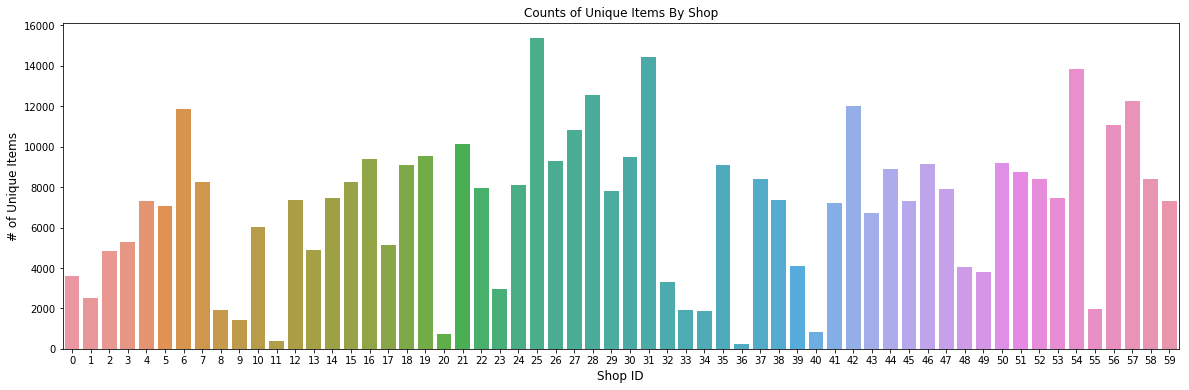

In [19]:
# Check the distribution of the number of unique items per shop
unique_items_by_shop = sales.groupby('shop_id')['item_id'].unique()
unique_item_cts_by_shop = unique_items_by_shop.map(len)
plt.figure(figsize=(20,6))
ax = sns.barplot(unique_item_cts_by_shop.index, unique_item_cts_by_shop.values)
plt.title("Counts of Unique Items By Shop")
plt.ylabel("# of Unique Items", fontsize=12)
plt.xlabel("Shop ID", fontsize=12)
plt.show()

In [20]:
# Check if there are changes in prices for same item
prices_by_item = sales.groupby('item_id')['item_price'].agg(['min','max']).reset_index()
prices_by_item.head(10)

,item_id,min,max
0,0,58.0,58.0
1,1,4490.0,4490.0
2,2,58.0,58.0
3,3,58.0,100.0
4,4,58.0,58.0
5,5,28.0,28.0
6,6,100.0,100.0
7,7,28.0,28.0
8,8,58.0,58.0
9,9,58.0,58.0


In [21]:
prices_by_item['price_changed'] = (prices_by_item['min'] != prices_by_item['max'])
prices_by_item.price_changed.value_counts()

True     15881
False     5926
Name: price_changed, dtype: int64

**FINDING:** About three-quarters of all items had different prices in the dataset.

In [22]:
prices_by_item.head(10)

,item_id,min,max,price_changed
0,0,58.0,58.0,False
1,1,4490.0,4490.0,False
2,2,58.0,58.0,False
3,3,58.0,100.0,True
4,4,58.0,58.0,False
5,5,28.0,28.0,False
6,6,100.0,100.0,False
7,7,28.0,28.0,False
8,8,58.0,58.0,False
9,9,58.0,58.0,False


In [34]:
# Determine if prices are always the same for one item on the same day, or if they vary by shop (and/or within one shop on same day)
prices_by_date_item = sales.groupby(['date','item_id'])['item_price'].agg(['min','max'])

In [35]:
prices_by_date_item.reset_index(inplace=True)
prices_by_date_item['diff_prices'] = (prices_by_date_item['min'] != prices_by_date_item['max'])
prices_by_date_item.head(10)

,date,item_id,min,max,diff_prices
0,2013-01-01,32,348.44,349.0,True
1,2013-01-01,33,499.00,499.0,False
2,2013-01-01,53,170.00,170.0,False
3,2013-01-01,59,110.00,249.0,True
4,2013-01-01,85,299.00,299.0,False
5,2013-01-01,98,268.00,399.0,True
6,2013-01-01,133,249.00,249.0,False
7,2013-01-01,154,299.00,299.0,False
8,2013-01-01,155,299.00,299.0,False
9,2013-01-01,354,258.00,258.0,False


In [36]:
prices_by_date_item.diff_prices.value_counts()

False    1426510
True      115104
Name: diff_prices, dtype: int64

**FINDING:** About 7.5% of date-item combinations show different prices.

In [28]:
prices_by_date_item_shop = sales.groupby(['date','item_id','shop_id'])['item_price'].agg(['min','max']).reset_index()

In [29]:
prices_by_date_item_shop.head()

,date,item_id,shop_id,min,max
0,2013-01-01,32,27,349.00,349.00
1,2013-01-01,32,28,349.00,349.00
2,2013-01-01,32,38,349.00,349.00
3,2013-01-01,32,42,348.44,348.44
4,2013-01-01,32,46,349.00,349.00


In [30]:
prices_by_date_item_shop['diff_prices'] = (prices_by_date_item_shop['min'] != prices_by_date_item_shop['max'])
prices_by_date_item_shop.diff_prices.value_counts()

False    2935799
True          22
Name: diff_prices, dtype: int64

<b>FINDING:</b> Based on the counts above, and the total number of rows in the sales dataset (2,935,843), there are 22 occasions when two different prices were used for same item in the same shop on the same day. On all other occasions, the same price was used in one shop for one item on the same day.

In [43]:
coef_of_var_by_shop_item = sales.groupby(['shop_id','item_id'])['item_price'].agg(variation)

In [69]:
coef_of_var_by_shop_item.sort_values(ascending=False).reset_index().rename(columns={'item_price':'coef_var'})[:10]

,shop_id,item_id,coef_var
0,7,11867,4.538900
1,28,11853,4.147582
2,14,11867,3.480296
3,15,11867,3.399952
4,56,11867,3.333000
5,42,11863,3.298889
6,17,11853,3.259849
7,25,20144,3.137431
8,38,11853,3.120867
9,25,11853,3.112585


In [64]:
sales[(sales.shop_id == 7) & (sales.item_id == 11867)][['date','shop_id','item_price']]

,date,shop_id,item_price
169627,2013-02-08,7,69.0
577400,2013-06-16,7,0.1
577401,2013-06-14,7,0.1
577402,2013-06-13,7,0.1
577403,2013-06-11,7,0.1
577404,2013-06-06,7,0.1
577405,2013-06-05,7,0.1
577406,2013-06-04,7,0.1
577600,2013-06-17,7,0.1
578189,2013-06-19,7,0.1


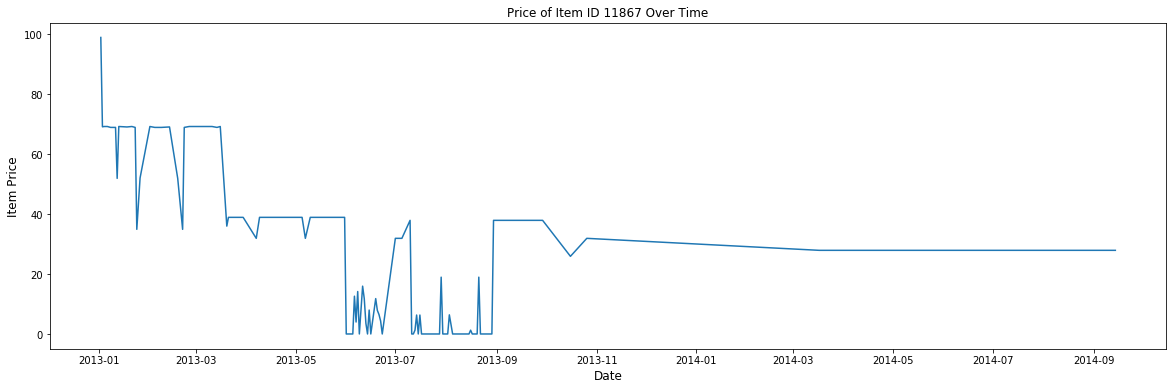

In [88]:
def plot_price_over_time(item):
    avg_item_prices_by_day = sales.groupby(['date','item_id'])['item_price'].mean().reset_index()
    plt.figure(figsize=(20,6))
    ax = sns.lineplot(avg_item_prices_by_day[avg_item_prices_by_day.item_id == item]['date'],
                      avg_item_prices_by_day[avg_item_prices_by_day.item_id == item]['item_price'])
    plt.title(f"Price of Item ID {item} Over Time")
    plt.ylabel("Item Price", fontsize=12)
    plt.xlabel("Date", fontsize=12)
    plt.show()
    
plot_price_over_time(11867)

In [66]:
coef_of_var_by_item = sales.groupby('item_id')['item_price'].agg(variation)

In [76]:
coef_of_var_by_item = coef_of_var_by_item.sort_values(ascending=False).reset_index().rename(columns={'item_price':'coef_var'})

In [77]:
coef_of_var_by_item[:10]

,item_id,coef_var
0,11860,4.016808
1,11872,3.369133
2,11866,3.057146
3,11855,2.517692
4,11856,2.338980
5,11863,2.308525
6,20144,2.299439
7,11859,2.259172
8,11853,2.228884
9,11365,2.177925


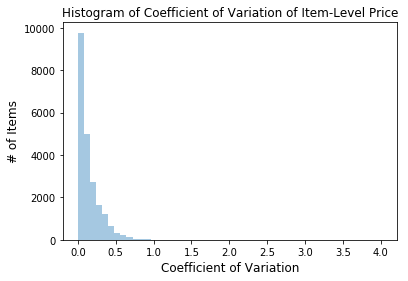

In [85]:
sns.distplot(coef_of_var_by_item.coef_var, kde=False)
plt.title("Histogram of Coefficient of Variation of Item-Level Price")
plt.xlabel("Coefficient of Variation", fontsize=12)
plt.ylabel("# of Items", fontsize=12)
plt.show()

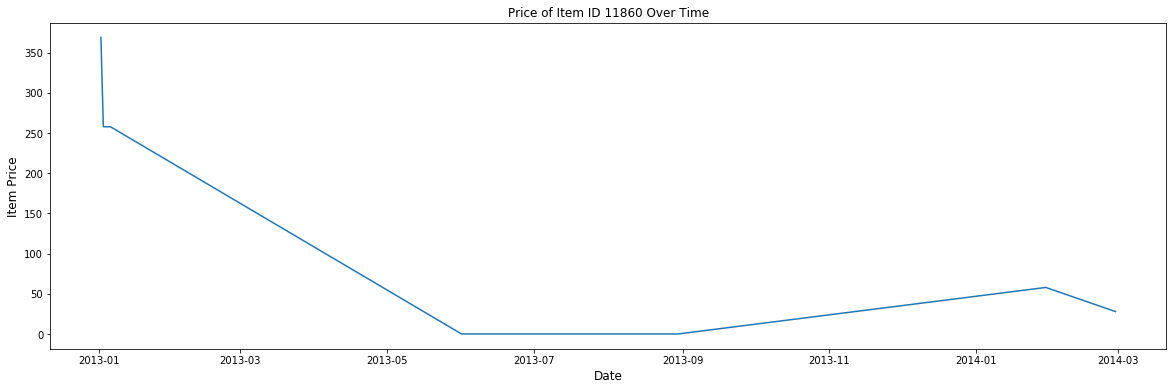

In [89]:
plot_price_over_time(11860)

### TEST DATASET 

In [91]:
test_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/test.csv')

In [92]:
test_df.shape

(214200, 3)

In [93]:
test_df.head(10)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


In [114]:
test_df.duplicated().any()

False

**FINDING:** No duplicates in the test dataset

In [115]:
test_df.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

**FINDING:** No missing values in the test dataset

In [94]:
len(test_df.shop_id.unique())

42

In [97]:
len(test_df.item_id.unique())

5100

In [98]:
np.setdiff1d(test_df.shop_id.unique(), sales.shop_id.unique())

array([], dtype=int64)

**FINDING:** All shop_id values in the test dataset also exist in the train dataset.

In [99]:
np.setdiff1d(sales.shop_id.unique(), test_df.shop_id.unique())

array([ 0,  1,  8,  9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51,
       54])

**FINDING:** 18 shop_id values above exist in the train dataset but do not exist in the test dataset.

In [101]:
np.setdiff1d(test_df.item_id.unique(), sales.item_id.unique()).size

363

**FINDING:** 363 item_id values exist in the test dataset, but do not exist in the train dataset.

In [104]:
np.setdiff1d(sales.item_id.unique(), test_df.item_id.unique()).size

17070

**FINDING:** 17,070 item_id values exist in the train dataset, but do not exist in the test dataset.

In [133]:
np.intersect1d(sales.item_id.unique(), test_df.item_id.unique()).size

4737

**FINDING:** 4,737 item_id values exist in both the train and test datasets.

### ITEMS SUPPLEMENTAL INFORMATION DATASET 

In [105]:
items_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/items.csv')

In [106]:
items_df.shape

(22170, 3)

In [126]:
items_df.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [134]:
# Need to check if all item_ids (in train and test datasets) exist in the items_df dataset
# Also need to check if the corresponding categories of those item_ids also all exist in the categories_df dataset

### ITEM CATEGORIES DATASET

In [108]:
categories_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/item_categories.csv')

In [109]:
categories_df.shape

(84, 2)

In [110]:
categories_df.head(10)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [112]:
categories_df.duplicated().any()

False

In [113]:
categories_df.isnull().sum()

item_category_name    0
item_category_id      0
dtype: int64

In [116]:
categories_df.item_category_id.unique().size

84

In [127]:
categories_df.item_category_name.unique().size

84

In [129]:
list(categories_df.item_category_name)

['PC - Гарнитуры/Наушники',
 'Аксессуары - PS2',
 'Аксессуары - PS3',
 'Аксессуары - PS4',
 'Аксессуары - PSP',
 'Аксессуары - PSVita',
 'Аксессуары - XBOX 360',
 'Аксессуары - XBOX ONE',
 'Билеты (Цифра)',
 'Доставка товара',
 'Игровые консоли - PS2',
 'Игровые консоли - PS3',
 'Игровые консоли - PS4',
 'Игровые консоли - PSP',
 'Игровые консоли - PSVita',
 'Игровые консоли - XBOX 360',
 'Игровые консоли - XBOX ONE',
 'Игровые консоли - Прочие',
 'Игры - PS2',
 'Игры - PS3',
 'Игры - PS4',
 'Игры - PSP',
 'Игры - PSVita',
 'Игры - XBOX 360',
 'Игры - XBOX ONE',
 'Игры - Аксессуары для игр',
 'Игры Android - Цифра',
 'Игры MAC - Цифра',
 'Игры PC - Дополнительные издания',
 'Игры PC - Коллекционные издания',
 'Игры PC - Стандартные издания',
 'Игры PC - Цифра',
 'Карты оплаты (Кино, Музыка, Игры)',
 'Карты оплаты - Live!',
 'Карты оплаты - Live! (Цифра)',
 'Карты оплаты - PSN',
 'Карты оплаты - Windows (Цифра)',
 'Кино - Blu-Ray',
 'Кино - Blu-Ray 3D',
 'Кино - Blu-Ray 4K',
 'Кино - DV

### SHOPS SUPPLEMENTAL INFORMATION DATASET

In [117]:
shops_df = pd.read_csv('./Data/competitive-data-science-predict-future-sales/shops.csv')

In [118]:
shops_df.shape

(60, 2)

In [119]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [121]:
shops_df.duplicated().any()

False

In [122]:
shops_df.isnull().sum()

shop_name    0
shop_id      0
dtype: int64

In [123]:
shops_df.shop_id.unique().size

60

In [124]:
shops_df.shop_name

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

In [12]:
# Aggregate to monthly level the required metrics
monthly_sales=sales.groupby(["date_block_num","shop_id","item_id"])[
    "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0